<a href="https://colab.research.google.com/github/Lemonfry/ds-section1-project/blob/main/section1-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

게임 개발을 위한 데이터 분석

---


목표 : 제일 잘 팔리는 게임 만들기

가진 데이터 : 무슨 장르의 게임이 어느 년도에 어떤 기종(platform)으로 출시되었으며, 만든 회사는 어디고 북미/유럽/일본/기타 지역에서의 출고 실적(

단순하게 생각한다면 가장 많이 팔리는 장르만 확인하여 모든 게임 기종으로 모든 지역에 판매하면 되겠으나, 개발 시간 제한 및 비용의 이유로 인해 그러기는 힘듭니다. 

그래서 잘 팔리는 게임을 위해선

1. 가장 많이 팔리는 장르
2. 가장 많이 팔리는 기종
3. 가장 많이 팔리는 지역

을 확인해야 합니다.

(분석을 위해, 출고량이 높으면 판매량도 많다고 생각하겠습니다)

진행 과정에 따른 설명은 코드를 참조해 주세요
1. 데이터 전처리(EDA)

In [1]:
# 기종 항목이 누락되어 한칸씩 당겨진 2개의 항목이 있어,(7597번, 16192번) 직접 수정합니다.
# 마찬가지로 연도가 네자리가 아닌 경우들도 직접 수정합니다.(14 -> 2014, 99 -> 1999, 0 -> 2000 등)

In [2]:
# 개인 노트북에 저장한 파일 불러오기
from google.colab import files
myfile = files.upload()

Saving vgames2_modified.csv to vgames2_modified.csv


In [3]:
import io
import pandas as pd
game_data = pd.read_csv(io.BytesIO(myfile['vgames2_modified.csv']))

In [4]:
# 데이터셋 확인(잘 불러와졌는지)
game_data

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...,...
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [5]:
# 현재 주어진 표에서, 게임 이름이나 게임 출판사와 출고량간에 관계가 있는지는 '다음 분기 게임 설계'를 위한 분석을 할 때는 별 필요가 없다고 판단됩니다.
# (EA 등의 소위 덩치가 큰 출판사가 당연히 더 많은 게임을 출고했겠으나, 게임을 만드는 입장에선 딱히 쓸모가 없는 정보입니다.)
# unamed:0와 사용하지 않을 게임 이름(name)과 출판사(publisher) column을 제거합니다
game_data = game_data.drop(['Unnamed: 0','Name','Publisher'], axis = 1)

In [6]:
game_data

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,2008.0,Action,0.04,0,0,0
1,Wii,2009.0,Action,0.17,0,0,0.01
2,PSP,2010.0,Adventure,0,0,0.02,0
3,DS,2010.0,Misc,0.04,0,0,0
4,PS3,2010.0,Platform,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...
16593,GC,2006.0,Platform,0.15,0.04,0,0.01
16594,PSP,2005.0,Action,0.01,0,0,0
16595,PS3,2015.0,Sports,0.44,0.19,0.03,0.13
16596,PSV,2013.0,Action,0.05,0.05,0.25,0.03


In [7]:
# Sales 항목의 수를 M(백만) 단위로 맞추기 : 여러 게임 관련 기사를 볼 때, 출고량의 기본 단위는 M이며 단위가 누락된 게임들도 M 단위 출고량에 더 가까운 것으로 보입니다.
# (단위 없는 판매량 중 1985 슈퍼마리오의 출고량이 41.49인데, 가디언지 온라인 기사에서 4000만장(40M) 팔렸단 기사로 볼때 M으로 계산 가능할 것으로 생각됨)
# https://www.theguardian.com/technology/gamesblog/2010/sep/13/games-gameculture, 10번항목
# 결론 : 단위 없으면 M으로 계산, K 단위는 M으로 변환합니다.

In [8]:
# M단위 통일을 위해 M단위는 문자만 없애고, K단위 발견시 K는 없애고 0.001을 곱합니다.
game_data.NA_Sales = (game_data.NA_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.NA_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.EU_Sales = (game_data.EU_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.EU_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.JP_Sales = (game_data.JP_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.JP_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.Other_Sales = (game_data.Other_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                         game_data.Other_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))

In [29]:
game_data

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,2008.0,Action,0.04,0.00,0.00,0.00
1,Wii,2009.0,Action,0.17,0.00,0.00,0.01
2,PSP,2010.0,Adventure,0.00,0.00,0.02,0.00
3,DS,2010.0,Misc,0.04,0.00,0.00,0.00
4,PS3,2010.0,Platform,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...
16593,GC,2006.0,Platform,0.15,0.04,0.00,0.01
16594,PSP,2005.0,Action,0.01,0.00,0.00,0.00
16595,PS3,2015.0,Sports,0.44,0.19,0.03,0.13
16596,PSV,2013.0,Action,0.05,0.05,0.25,0.03


2. 항목분석

(1) 지역별 선호 게임 장르

In [10]:
# 장르 항목의 중복을 제거하고 몇종류가 있는지를 파악하고, 각 장르마다 각 지역에서 얼마나 출고되었는지를 확인합니다.

In [11]:
# 중복되지 않는 장르 목록을 확인합니다.
print(game_data['Genre'].unique())

['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter' nan]


In [82]:
# 장르 이름이 없어 생겨난 nan을 장르 목록에서 제거합니다.
import numpy as np
import math

Genre_list = game_data['Genre'].unique()
Genre_list = Genre_list.tolist()
Genre_list.pop(12)
Genre_list

['Action',
 'Adventure',
 'Misc',
 'Platform',
 'Sports',
 'Simulation',
 'Racing',
 'Role-Playing',
 'Puzzle',
 'Strategy',
 'Fighting',
 'Shooter']

In [46]:
Year_list = game_data['Year'].unique()
Year_list = Year_list.tolist()
Year_list = sorted(Year_list)
Year_list.pop(36)
Year_list

[1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2020.0]

In [47]:
Region = ['NA','EU','JP','Other']

In [145]:
# 각 장르별 출고량을 각 지역마다 합하여 계산하고, list에 저장합니다.
NA_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'NA_Sales'].sum()
  NA_Genre_Sales.append(i)

EU_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'EU_Sales'].sum()
  EU_Genre_Sales.append(i)

JP_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'JP_Sales'].sum()
  JP_Genre_Sales.append(i)

Other_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'Other_Sales'].sum()
  Other_Genre_Sales.append(i)

In [146]:
# 바로 위에서 계산된 list들을 dataframe으로 만들어, 4개 지역에서 각 장르별 게임 출고량을 표로 보여줍니다.
import pandas as pd
genre_sales = pd.DataFrame([NA_Genre_Sales])
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = EU_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = JP_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = Other_Genre_Sales

In [147]:
genre_sales.columns = Genre_list
genre_sales['Region'] = Region
genre_sales = genre_sales.set_index(['Region'])

In [151]:
genre_sales

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Region,,,,,,,,,,,,
NA,874.81,105.66,408.05,446.44,680.52,182.96,357.19,319.54,123.35,68.70,223.20,581.92
EU,522.16,64.05,212.36,201.61,376.48,113.35,237.10,183.58,50.73,45.32,101.22,313.05
JP,157.90,51.95,105.27,130.65,135.37,63.70,56.40,344.95,56.87,49.46,87.34,38.28
Other,186.45,16.81,74.04,51.53,134.67,31.48,77.10,56.96,12.52,11.36,36.64,102.65


AxesSubplot(0.125,0.125;0.775x0.755)


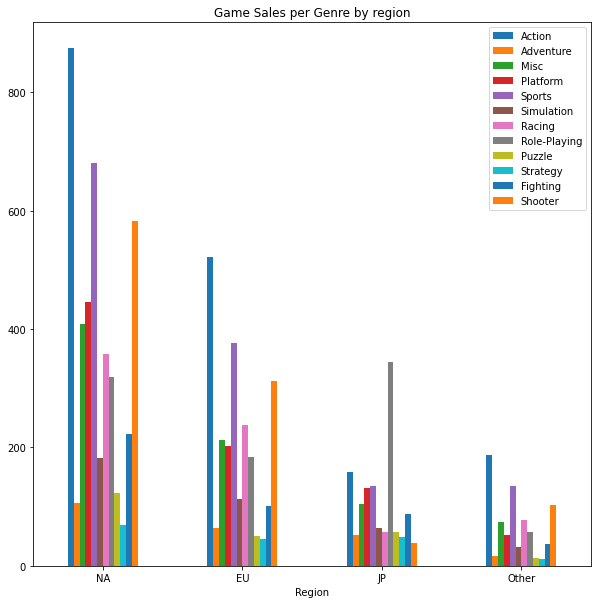

In [155]:
# 위 데이터는 막대그래프로 보는게 제일 보기 쉬울것으로 보이므로, 막대그래프로 시각화 해 보겠습니다.
import matplotlib.pyplot as plt
genre_barplot = genre_sales.plot.bar(title="Game Sales per Genre by region", rot=0, figsize=(10,10))
print(genre_barplot)
plt.show()

그래프에서 볼 수 있듯, 일본(JP)을 제외하고 모든 지역에서는 액션 게임이 제일 출고량이 많으며, 그 뒤로는 스포츠 게임, 슈팅 게임의 출고량이 많습니다.

일본의 경우, 롤플레잉 게임의 출고량이 1위이며, 그 뒤로 액션, 스포츠 게임의 출고량이 많습니다.

이 결과만을 볼 때, 다음 분기 출시해야 할 게임 장르의 순위는
1. 액션
2. 스포츠
3. 슈팅

으로 생각할 수 있습니다.